# Deep convolutional networks for feature selection in statistical downscaling

***8th International Workshop on Climate Informatics 2018 (Colorado, EEUU)***

**J. Baño-Medina and J.M. Gutiérrez**

http://dx.doi.org/10.5065/D6BZ64XQ

GitHub repository at https://github.com/SantanderMetGroup/DeepDownscaling

This notebook reproduces the results published in the [conference paper](https://github.com/SantanderMetGroup/DeepDownscaling/blob/master/2018_Bano_CI.pdf) titled *Deep convolutional networks for feature selection in statistical downscaling by J. Baño-Medina and J. M. Gutiérrez, in the 8th International Workshop on Climate Informatics held in Boulder, Colorado (EEUU) in 2018. In particular, the code developed herein evaluates the suitability of convolutional networks for the downscaling of the occurrence of precipitation and delves into the predictor-predictand link by highlighting the most relevant variables in the downscaling. We focus on the 86 stations proposed in the [VALUE validation experimental framework](http://www.value-cost.eu).

Note: This notebook is written in the free programming language R and builds on the R framework [climate4R](https://github.com/SantanderMetGroup/climate4R) (C4R hereafter, conda and docker installations available), a suite of R packages developed by the [Santander Met Group](http://meteo.unican.es/en/main) for transparent climate data access, post processing (including bias correction and downscaling, via the downscaleR package; [Bedia et al. 2020](https://gmd.copernicus.org/articles/13/1711/2020/gmd-13-1711-2020-discussion.html)) and visualization. The interested reader is referred to [Iturbide et al. 2019](https://www.sciencedirect.com/science/article/abs/pii/S1364815218303049?via%3Dihub).

# 1. Loading Libraries
In this study, we build on C4R, which is used for loading and post-processing, downscaling, validation and visualization. Different sectorial [notebooks](https://github.com/SantanderMetGroup/notebooks) are available illustrating the use of C4R functions. The C4R libraries that are needed to run this notebook can be installed through the devtools package (e.g. devtools::install_github("SantanderMetGroup/loadeR") for loadeR); see detailed instructions [here](https://github.com/SantanderMetGroup/climate4R). The deep learning models used in this work are implemented in [downscaleR.keras](https://github.com/SantanderMetGroup/downscaleR.keras), an extension of downscaleR which integrates keras in the C4R.

In [ ]:
library(loadeR) # version 1.6.1 
library(transformeR) # version 1.7.4
library(downscaleR) # version 3.1.3
library(visualizeR) # version 1.5.1
library(climate4R.value) # version 0.0.2 (also relies on VALUE version 2.2.1)
library(downscaleR.keras) # version 1.0.0 (relies on keras version 2.2.2 and tensorflow version 2.0.0)

library(magrittr)
library(gridExtra) # for plotting functionalities
library(RColorBrewer) # for plotting functionalities
library(sp) # for plotting functionalities

# 2. Loading Data
In this section we describe how to load into our R session the predictor and predictand datasets involved in this study; ERA-Interim, and E-OBS (version 14), respectively. In this study we rely on the [User Data Gateway (UDG)](http://meteo.unican.es/udg-tap/home), a THREDDS-based service from the Santander Climate Data Service (CDS) to load the data into our session (register [here](http://meteo.unican.es/udg-tap/signup) freely to get a user). We can log in using the `loginUDG` function from loadeR:

In [ ]:
loginUDG(username = "***", password = "***")

We find the label associated to ERA-Interim via the `UDG.datasets` function of library `loadeR`: **“ECMWF_ERA-Interim-ESD”**  (type `?UDG.datasets()` for information on the full list of datasets available at UDG). Then we load the predictors by calling `loadGridData` of `loadeR`. In particular, we load the Iberia region (IP) defined in the Prudence regions, which are stored as an object in library `visualizeR`. We then use the `lonLim` and `latLim` arguments to define the domain and `years` to load daily data for the period 1979-2008.

We loop over the `loadGridData` function to load a different predictor variable at each iteration. Since we rely on the perfect-prognosis approach of statistical downscaling models, we load those predictor variables that are reliably represented by GCMs (despite the fact in this study we only work in the observational space with reanalysis data): geopotential, specific humidity, air temperature, and the zonal and meridional wind velocities at 500, 700, 850 and 1000hPa. The code of these variables can be found by calling `C4R.vocabulary` of `loadeR`.

In [ ]:
variables <- c("z@500","z@700","z@850","z@1000",
               "hus@500","hus@700","hus@850","hus@1000",
               "ta@500","ta@700","ta@850","ta@1000",
               "ua@500","ua@700","ua@850","ua@1000",
               "va@500","va@700","va@850","va@1000")
x <- lapply(variables, function(x) {
  loadGridData(dataset = "ECMWF_ERA-Interim-ESD",
               var = x,
               lonLim = c(-10,32), 
               latLim = c(36,72),  
               years = 1979:2008)
}) %>% makeMultiGrid() %>% redim(drop = TRUE)

We load the 86 VALUE stations, which are stored in the `VALUE` package as zip files. This can be done by calling `loadStationData` from `loadeR` and download the precipitation (coded as `precip`) as defined by the daily total rainfall amount in mm/day for the temporal period 1979-2008. Since the objective is to downscale the occurrence of precipitation, we convert the precipitation serie to a binary temporal serie (0:1, norain/rain) imposing a threshold of 1mm, such that every day where the rainfall amount is greather than 1mm then this is considered to be a rainy day.

In [ ]:
value.path <- file.path(find.package("VALUE"), "example_datasets", "VALUE_ECA_86_v2.zip")
y <- loadStationData(dataset = value.path, var = "precip", years = 1979:2008) %>% 
  binaryGrid(threshold = 1, condition = "GT")

We depict the region of study, together with the predictor and predictand regular and irregular grids, and the PRUDENCE regions in colors. The PRUDENCE regions domains are directly stored in `visualizeR` as an `R` object.

[2021-01-12 10:55:46] - Computing climatology...

[2021-01-12 10:55:46] - Done.



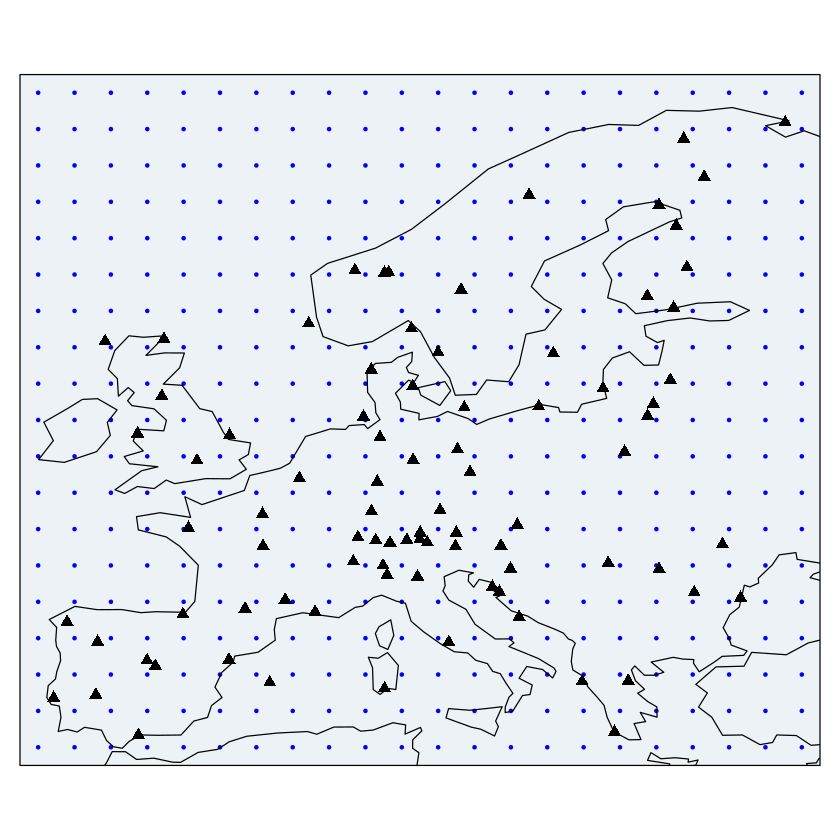

In [ ]:
areas <- PRUDENCEregions
n <- names(PRUDENCEregions)
coords <- expand.grid(x$xyCoords$x,x$xyCoords$y) ; names(coords) <- c("x","y")
spatialPlot(climatology(subsetGrid(x,var = "z@500")), backdrop.theme = "coastline",set.min = -9999, set.max = -9998,  
            col.regions = colorRampPalette(rev(brewer.pal(n = 9, "RdBu"))),
                          sp.layout = list(list(SpatialPoints(coords), first = FALSE, col = "blue", pch = 20, cex = 0.5), 
                                           list(SpatialPoints(y$xyCoords), first = FALSE, col = "black", pch = 17, cex = 1),
                                           list(areas[1], col = "red"),
                                           list(areas[2], col = "yellow"),
                                           list(areas[3], col = "orange"),
                                           list(areas[5], col = "green"),
                                           list(areas[4], col = "purple"),
                                           list(areas[6], col = "pink"),
                                           list(areas[7], col = "grey"),
                                           list(areas[8], col = "blue")), colorkey = FALSE)

# 3. Downscaling
In this section we provide the code necessary to build the convolutional models together with the generalized linear model used as benchmark. To do so we rely on `downscaleR.keras` library to build the neural networks and the `downscaleR` package to build the linear models.

Prior to the building of the models, we split the data into a train (1979-2002) and test (2003-2008) temporal periods using `subsetGrid` of `transformeR` and scale/standardize the resulting objects using `scaleGrid` according to the training temporal statistics.

In [ ]:
# Predictors
# x <- subsetGrid(x, var = c("z@500", "z@850", "z@1000", "hus@700", "hus@850", "ta@700", "ta@850")) # UNCOMMENT THIS LINE TO USE ONLY THE SUBSET OF VARIABLES USED FOR SOME METHODS IN VALUE
xT <- subsetGrid(x, years = 1979:2002)
xt <- subsetGrid(x, years = 2003:2008) %>% scaleGrid(base = xT, type = "standardize")
xT %<>% scaleGrid(type = "standardize")

In [ ]:
# Predictands
yT <- subsetGrid(y, years = 1979:2002)
yt <- subsetGrid(y, years = 2003:2008)

We remove the days that contain NaN from the training data in the predictand dataset using `filterNA` and the intersect temporally with the predictor training data, using `getTemporalIntersection`.

In [ ]:
yT %<>% filterNA()
xT %<>% getTemporalIntersection(yT)

We would be relying on the function `valueMeasure` from `climate4R.value` library to compute the ROC Skill Score (ROCSS) to validate the prediction temporal series over the test period for each of the downscaling models.

## 3.1 GLM1, GLM4, GLM-PC
In this section we develop the code necessary to reproduce 3 GLMs with different predictor configurations. In particular we build logistic regression models by setting the arguments `method = "GLM"` and `family = binomial(link = "logit")`. 

We build two GLMs which are based on a moving window that cover the 1/4 closest gridpoints to each of the locations encoded as GLM1 and GLM4, respectively. The code necessary to build these models can be found below:

In [ ]:
auc <- sapply(c(1,4), FUN = function(z){
    xyT <- prepareData(xT,yT,local.predictors = list(n = z, vars = getVarNames(x)))
    model <- downscaleTrain(xyT, method = "GLM", family = binomial(link = "logit"))
    xyt <- prepareNewData(xt,xyT) 
    pred <- downscalePredict(xyt,model)
    valueMeasure(yt,pred,measure.code = "ts.rocss")$Measure$Data  
})

The third GLM configuration is based on the principal components infered at each of the 8 PRUDENCE regions. Therefore, if a VALUE station is located e.g., on the Iberian Peninsula, then the predictors are those that explaing the 95% of the total variance of the predictor space over the Iberian PRUDENCE region.

In [ ]:
pred <- lapply(1:length(areas), FUN = function(z) {
    xlim <- areas[n[z]]@bbox[1,]
    ylim <- areas[n[z]]@bbox[2,]
    xT %<>% subsetGrid(lonLim = xlim,latLim = ylim) # domain of a PRUDENCE region
    xt %<>% subsetGrid(lonLim = xlim,latLim = ylim) # domain of a PRUDENCE region
    indY <- which(y$xyCoords$y >= ylim[1] & y$xyCoords$y <= ylim[2])
    indX <- which(y$xyCoords$x >= xlim[1] & y$xyCoords$x <= xlim[2])
    ind <- intersect(indX,indY)
    if (n[z] == "SC") ind <- c(ind,sapply(c("000194","000195"),FUN = function(zz) which(y$Metadata$station_id == zz)))
    if (n[z] == "ME") {indParis <- which(y$Metadata$station_id[ind] == "000038"); ind <- setdiff(ind,ind[indParis])}
    if (n[z] == "EA") ind <- c(ind,sapply(c("001684","000021","000012"),FUN = function(zz) which(y$Metadata$station_id == zz)))                                  
    yT %<>% subsetGrid(station.id = y$Metadata$station_id[ind])
    yt %<>% subsetGrid(station.id = y$Metadata$station_id[ind])
    xyT <- prepareData(xT,yT,spatial.predictors = list(v.exp = 0.95,which.combine = getVarNames(x)))
    model <- downscaleTrain(xyT, method = "GLM", family = binomial(link = "logit"))
    xyt <- prepareNewData(xt,xyT) 
    pred <- downscalePredict(xyt,model)
}) %>% bindGrid(dimension = "loc") %>% matchStations(y)
auc <- cbind(auc,valueMeasure(yt,pred,measure.code = "ts.rocss")$Measure$Data)  

## 3.2 CNN1, CNN10
In this section we provide the code necessary to build the convolutional models that consist on a 3-convolutional layer with a kernel size of 3x3 and 50, 25, and 1/10 of filter maps respectively. The channels stacked on the input space depends on the predictor variables used (i.e., the whole set are 20 variables) and the output space results into a vector of probabilities with a total of 86 output neurons, i.e., one for each VALUE station. We define a function called `topology` that parameterizes some aspects of the keras model: the channels on the input space and the number of filter maps in the last hidden layer.

In [ ]:
topology <- function(predictor_data,last_filter_map) {
  inputs <- layer_input(shape = c(getShape(predictor_data,"lat"),getShape(predictor_data,"lon"),getShape(predictor_data,"var")))
  l0 = inputs
  l1 = layer_conv_2d(l0 ,filters = 50, kernel_size = c(3,3), activation = 'relu', padding = "same")
  l2 = layer_conv_2d(l1,filters = 25, kernel_size = c(3,3), activation = 'relu', padding = "same")
  l3 = layer_conv_2d(l2,filters = last_filter_map, kernel_size = c(3,3), activation = 'relu', padding = "same")
  l4 = layer_flatten(l3)
  outputs = layer_dense(l4,units = 86, activation = "sigmoid")
  model <- keras_model(inputs = inputs, outputs = outputs)
}

We prepare the predictor and predictand datasets for integration with keras with the functions prepareData.keras and prepareNewData.keras

In [ ]:
xyT <- prepareData.keras(xT,yT,
                          first.connection = "conv",
                          last.connection = "dense",
                          channels = "last")
xyt <- prepareNewData.keras(xt,xyT)

We build the convolutional models by calling the function `downscaleTrain.keras` of the `downscaleR.keras` library and then use this model to predict over the test temporal serie using `downscalePredict.keras`. This model is trained by optimizing the cross-entropy and using an Adam optimizer with a learning rate of 1e-4, a batch sixe of 100, and applying early-stopping with a patience of 30 using the 10% of the training data as a validation dataset. The model is stored in the working directory using a keras `callback` and cleared from the working space after the predictions are computed. Finally we compute the ROC Skill Score (ROCSS) using the `valueMeasure` function.

In [ ]:
auc.cnn <- sapply(c(1,10), FUN = function(z) {
  downscaleTrain.keras(obj = xyT,
                       model = topology(predictor_data = x, last_filter_map = z),
                       clear.session = TRUE,
                       compile.args = list("loss" = "binary_crossentropy",
                                           "optimizer" = optimizer_adam(lr = 0.0001)),
                       fit.args = list("batch_size" = 100,
                                       "epochs" = 1000,
                                       "validation_split" = 0.1,
                                       "verbose" = 1,
                                       "callbacks" = list(callback_early_stopping(patience = 30),
                                                 callback_model_checkpoint(filepath=paste0(paste0("CNN",z,"_",getShape(x,"var"),".h5")),monitor='val_loss', save_best_only=TRUE))))
  pred <- downscalePredict.keras(newdata = xyt,
                                 model = list("filepath" = paste0("CNN",z,"_",getShape(x,"var"),".h5")),
                                 C4R.template = yT,
                                 clear.session = TRUE)
  valueMeasure(yt,pred, measure.code = "ts.rocss")$Measure$Data  
})
auc <- cbind(auc,auc.cnn)

# 4. Validation of the results (ROC Skill Score (ROCSS))
In this section we plot the ROCSS values for the 5 downscaling models (GLM1, GLM4, GLMPC, CNN1, CNN10) for the 86 VALUE stations. 

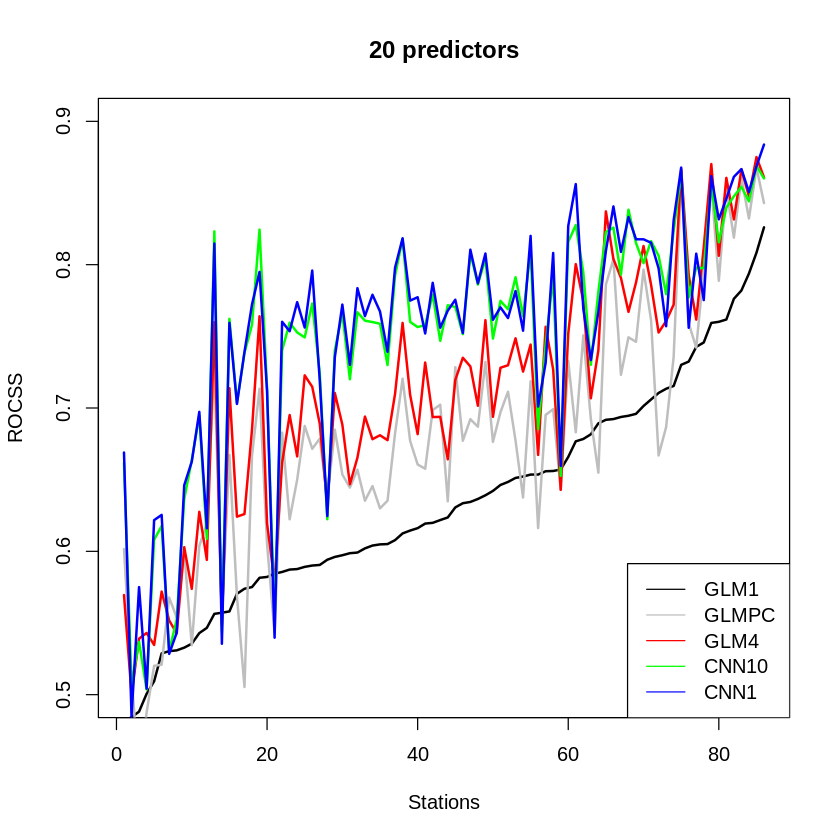

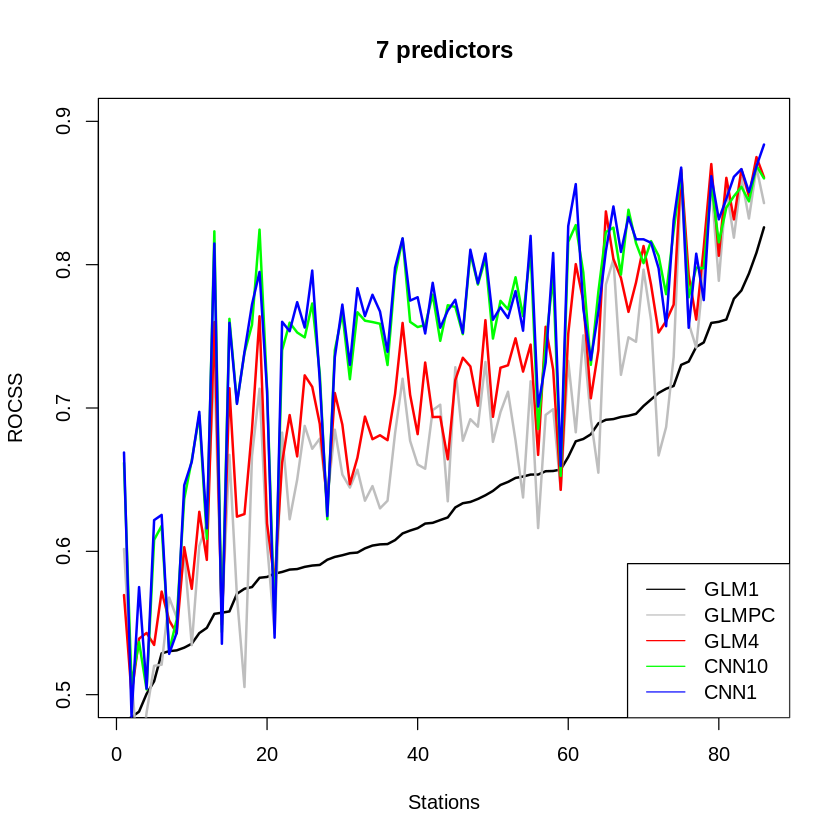

In [ ]:
ind.ord <- sort.int(auc[,1],index.return = TRUE)$ix
auc.ord <- auc[ind.ord,]
plot(auc.ord[,1], type = "l", lwd = 2, col = c("black","gray","red","green","blue"), ylim = c(0.5,0.90), xlab = "Stations", ylab = "ROCSS", main = "20 predictors")
lines(auc.ord[,3], lwd = 2, col = "gray")
lines(auc.ord[,2], lwd = 2, col = "red")
lines(auc.ord[,5], lwd = 2, col = "green")
lines(auc.ord[,4], lwd = 2, col = "blue")
legend("bottomright", legend = c("GLM1","GLMPC","GLM4","CNN10","CNN1"), col = c("black","gray","red","green","blue"), lty = c(1,1,1,1,1))

##  Only in case you have tried the configuration with the subset of 7 variables indicated above in the notebook
# ind.ord <- sort.int(auc[,1],index.return = TRUE)$ix
# auc.ord <- auc[ind.ord,]
# plot(auc.ord[,1], type = "l", lwd = 2, col = c("black","gray","red","green","blue"), ylim = c(0.5,0.90), xlab = "Stations", ylab = "ROCSS", main = "7 predictors")
# lines(auc.ord[,3], lwd = 2, col = "gray")
# lines(auc.ord[,2], lwd = 2, col = "red")
# lines(auc.ord[,5], lwd = 2, col = "green")
# lines(auc.ord[,4], lwd = 2, col = "blue")
# legend("bottomright", legend = c("GLM1","GLMPC","GLM4","CNN10","CNN1"), col = c("black","gray","red","green","blue"), lty = c(1,1,1,1,1))

# 5. Visualization of the predictor-predictand link
In this section we delve into the hidden knowledge of the CNN1 model, by looking at the coefficients that link the last hidden layer with the output neurons, and 2) looking the similarity between the filter map and the predictor variables at a given day.

Therefore we load the model in the next chunk of code:

In [ ]:
model <- list("filepath" = paste0("CNN1_",getShape(x,"var"),".h5"))
model <- do.call("load_model_hdf5",model)
model

Model
Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 19, 22, 20)]            0           
________________________________________________________________________________
conv2d (Conv2D)                     (None, 19, 22, 50)              9050        
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 19, 22, 25)              11275       
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 19, 22, 1)               226         
________________________________________________________________________________
flatten (Flatten)                   (None, 418)                     0           
________________________________________________________________________________
dense (

## 5.1 Visualization of the coefficients
To visualize the last layer's coefficients we use the funcion `downscalePredictHidden.keras` that returns the kernels/coefficients for a given layer. Since we are interested in the last one, we set `layer = "dense"` for the CNN1 model. We reshape the coefficient matrix and use a `template` to create an appropiate `weights` object where to store the coefficients.

In [ ]:
weights <- subsetGrid(x,var = "z@500")
weights$Data <- downscalePredictHidden.keras(newdata = xyt,layer = "dense",
                                     model = list("filepath" = paste0("CNN1_",getShape(x,"var"),".h5")),
                                     clear.session = TRUE)$kernel[[1]] 
dim(weights$Data) <- c(22,19,86)
weights$Data %<>% aperm(c(3,2,1))
attr(weights$Data,"dimensions") <- c("time","lat","lon")

To highlight the influence of the most important gridpoints we perform some kind of moving average that we define in the below function `mask_weights`.

In [ ]:
mask_weights <- function(w,a) {
  pad <- floor(a/2)
  w_pad <- matrix(data = 0, ncol = ncol(w) + 2*pad, nrow = nrow(w) + 2*pad)
  w_pad[(pad+1):(nrow(w_pad)-pad),(pad+1):(ncol(w_pad)-pad)] <- w
  mask <- matrix(data = 0, ncol = ncol(w), nrow = nrow(w))
  for (i in (1 + pad):(nrow(w_pad) - pad)) {
    for (j in (1 + pad):(ncol(w_pad) - pad)) {
      mask[(i-pad),(j-pad)] <- sum(w_pad[(i - pad):(i + pad),(j - pad):(j + pad)])
      # mask[(i-pad),(j-pad)] <- sum(w_pad[(i - pad):(i + pad),(j - pad):(j + pad)])/length(which(w_pad[(i - pad):(i + pad),(j - pad):(j + pad)] != 0))
    }
  }
  return(mask)
}

We call the above function over the `weights` object.

In [ ]:
for (i in 1:86) weights$Data[i,,] <- mask_weights(weights$Data[i,,],5)
attr(weights$Data,"dimensions") <- c("time","lat","lon")

We use the funcion spatialPlot to depict the coefficients, since the latitude-longitude are mantained after the convolutional layers, these can be interpreted spatially. In particular we depict the coefficients associated to the VALUE stations of Madrid and Helsinki, which have different climatological properties.

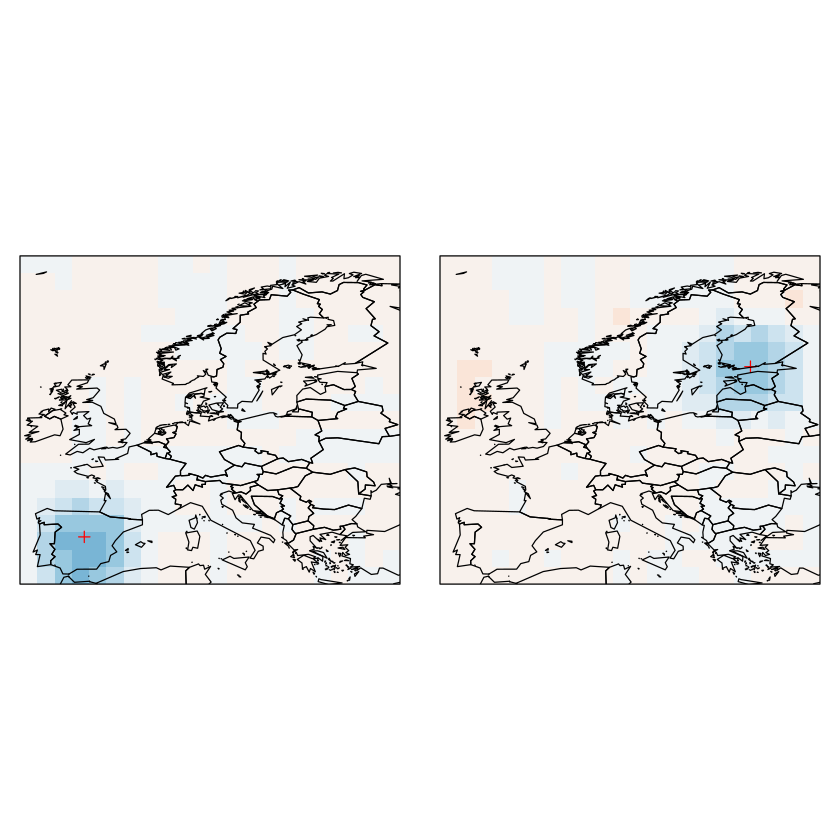

In [ ]:
pplot <- lapply(c(80,8), FUN = function(z){
    spatialPlot(subsetDimension(weights,dimension = "time", indices = z), backdrop.theme = "countries",  
                at = seq(-5, 5, 0.5), set.min = -5, set.max = 5,
                col.regions = colorRampPalette(rev(brewer.pal(n = 9, "RdBu"))), 
                sp.layout = list(list(SpatialPoints(y$xyCoords[z,]), first = FALSE, col = "red")), colorkey = FALSE)
})
grid.arrange(grobs = pplot, ncol = 2)

### 5.2 Visualization of the filter maps
To evaluate the predictor selection that has occurred within the hidden layers of the CNN1 model we compare the last single filter map with the predictor fields for a given day. The prediction for the last filter map (layer 4 of the model) can be returned by calling `downscalePredictHidden.keras` of `downscaleR.keras`and setting `layer = 4` of the CNN1 model. Previously, we use the variable `z@500` as template where to store the prediction, since the metadata is the same for both objects.

In [ ]:
predHidden <- subsetGrid(x,var = "z@500")
predHidden$Data <- downscalePredictHidden.keras(newdata = xyt,layer = 4,
                                     model = list("filepath" = paste0("CNN1_",getShape(x,"var"),".h5")),
                                     clear.session = TRUE)$filterMap$member_1

Once we obtained the prediction of the last single layer map, we call `spatialPlot` within a loop to depict the fields of the 20 variables plus the filter map for a given day (`day`).

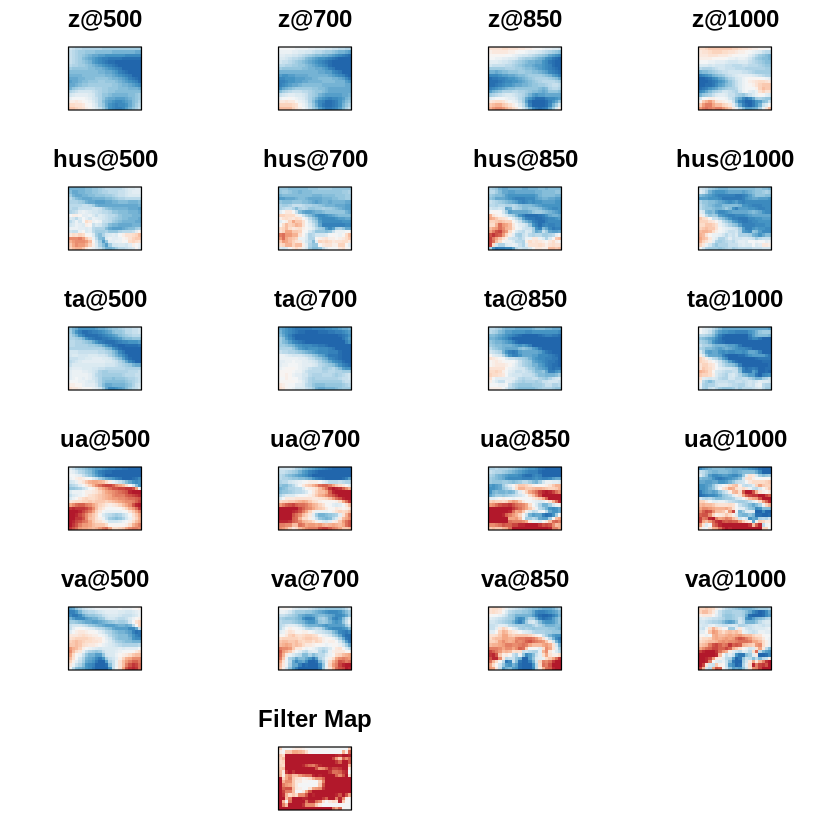

In [ ]:
day <- 1
pplot <- lapply(1:21, FUN = function(z){
    if (z <= 20) {
      grid <- subsetGrid(subsetDimension(xt, dimension = "time", indices = day),var = getVarNames(x)[z])
      main <- getVarNames(x)[z]  
    } else if (z == 21) {
      grid <- subsetDimension(predHidden, dimension = "time", indices = day)
      main = "Filter Map"
    }
    spatialPlot(grid, at = seq(-2, 2, 0.1), set.min = -2, set.max = 2, colorkey = FALSE, 
                col.regions = colorRampPalette(rev(brewer.pal(n = 9, "RdBu"))),
               main = main)      
})              
lay = rbind(c(1, 2,  3, 4),
            c(5, 6 , 7, 8),
            c(9, 10,11,12),
            c(13,14,15,16),
            c(17,18,19,20),
            c(NA,21,NA,NA))
grid.arrange(grobs = pplot, layout_matrix = lay)